In [1]:
import matplotlib.pyplot as plt
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import FuncFormatter

In [2]:
# Instalamos la última versión de Tensorflow (con CUDA)
%pip install tensorflow[and-cuda]

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nccl-cu12
   

In [3]:
# Configuración inicial
base_path = "/kaggle/input/all-in1-v2/all_in_one_extended_v2"  # Cambia esto por la ruta de tu carpeta principal
train_path = "/kaggle/working/train"          # Directorio para imágenes de entrenamiento
test_path = "/kaggle/working/test"            # Directorio para imágenes de prueba
min_images = 10                           # Número mínimo de imágenes por fabricante
test_split = 0.2                           # Proporción de imágenes para test

epochs_for_training = 30
batchsize_for_training = 16

# Paso 1: Filtrar fabricantes con más de N imágenes
fabricantes = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

print(fabricantes)
print(len(fabricantes))

['zte', 'fortinet', 'asus', 'paloalto', 'mikrotik', 'dlink', 'pfsense', 'draytek', 'watchguard']
9


In [4]:
# Función para aumentar datos
def augment_images(fabricante_path, target_count, output_dir):
    datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.01,
        height_shift_range=0.01,
        shear_range=0,
        zoom_range=0.01,
        horizontal_flip=False,
        fill_mode='nearest'
    )
    
    # Crear carpeta para imágenes aumentadas
    augmented_dir = os.path.join(output_dir, os.path.basename(fabricante_path))
    if not os.path.exists(augmented_dir):
        os.makedirs(augmented_dir)
    
    images = os.listdir(fabricante_path)
    current_count = len(images)
    augmented_count = 0
    
    while current_count + augmented_count < target_count:
        for image_name in images:
            if augmented_count >= target_count - current_count:
                break
            img_path = os.path.join(fabricante_path, image_name)
            img = Image.open(img_path).convert("RGB")
            img_array = np.expand_dims(np.array(img), axis=0)
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir, save_prefix="aug", save_format="jpeg"):
                augmented_count += 1
                break  # Genera solo una imagen por iteración
    print(f"Datos aumentados para {fabricante_path}: {augmented_count} nuevas imágenes generadas.")

In [5]:
# Crear carpeta de datos ajustados si no existe
output_path_adjusted = "/kaggle/working/adjusted"
base_path = "/kaggle/input/all-in1-v2/all_in_one_extended_v2"

if not os.path.exists(output_path_adjusted):
    os.makedirs(output_path_adjusted)

# Ajustar todas las clases a 100 imágenes
target_count = 100

for fabricante in fabricantes:
    fabricante_path = os.path.join(base_path, fabricante)
    adjusted_fabricante_path = os.path.join(output_path_adjusted, fabricante)
    
    # Crear carpeta del fabricante en el directorio ajustado si no existe
    if not os.path.exists(adjusted_fabricante_path):
        os.makedirs(adjusted_fabricante_path)
    
    images = os.listdir(fabricante_path)
    current_count = len(images)
    
    # Si tiene más de 100 imágenes, seleccionamos aleatoriamente 100
    if current_count > target_count:
        selected_images = random.sample(images, target_count)
        for image_name in selected_images:
            original_image_path = os.path.join(fabricante_path, image_name)
            destination_image_path = os.path.join(adjusted_fabricante_path, image_name)
            shutil.copy(original_image_path, destination_image_path)
    
    # Si tiene menos de 100 imágenes, copiamos todas y generamos aumentadas
    elif current_count < target_count:
        # Copiar imágenes originales
        for image_name in images:
            original_image_path = os.path.join(fabricante_path, image_name)
            destination_image_path = os.path.join(adjusted_fabricante_path, image_name)
            shutil.copy(original_image_path, destination_image_path)
        
        # Aumentar imágenes para alcanzar el target_count
        augment_images(fabricante_path, target_count, output_path_adjusted)
    
    # Si tiene exactamente 100 imágenes, las copiamos directamente
    else:
        for image_name in images:
            original_image_path = os.path.join(fabricante_path, image_name)
            destination_image_path = os.path.join(adjusted_fabricante_path, image_name)
            shutil.copy(original_image_path, destination_image_path)


# Paso 3: Reorganizar imágenes en carpetas de train y test
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

train_counts = {}
test_counts = {}

for fabricante in fabricantes:
    fabricante_path = os.path.join(output_path_adjusted, fabricante)
    images = os.listdir(fabricante_path)
    random.shuffle(images)
    
    # Dividir en train y test
    split_index = int(len(images) * (1 - test_split))
    train_images, test_images = images[:split_index], images[split_index:]
    
    # Contar imágenes por clase
    train_counts[fabricante] = len(train_images)
    test_counts[fabricante] = len(test_images)
    
    # Mover imágenes
    for img_set, dest_path in [(train_images, train_path), (test_images, test_path)]:
        dest_dir = os.path.join(dest_path, fabricante)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        for img in img_set:
            shutil.copy(os.path.join(fabricante_path, img), os.path.join(dest_dir, img))



Datos aumentados para /kaggle/input/all-in1-v2/all_in_one_extended_v2/asus: 21 nuevas imágenes generadas.
Datos aumentados para /kaggle/input/all-in1-v2/all_in_one_extended_v2/paloalto: 25 nuevas imágenes generadas.
Datos aumentados para /kaggle/input/all-in1-v2/all_in_one_extended_v2/dlink: 20 nuevas imágenes generadas.
Datos aumentados para /kaggle/input/all-in1-v2/all_in_one_extended_v2/pfsense: 18 nuevas imágenes generadas.
Datos aumentados para /kaggle/input/all-in1-v2/all_in_one_extended_v2/draytek: 27 nuevas imágenes generadas.
Datos aumentados para /kaggle/input/all-in1-v2/all_in_one_extended_v2/watchguard: 30 nuevas imágenes generadas.


Distribución de imágenes en el conjunto de entrenamiento:


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


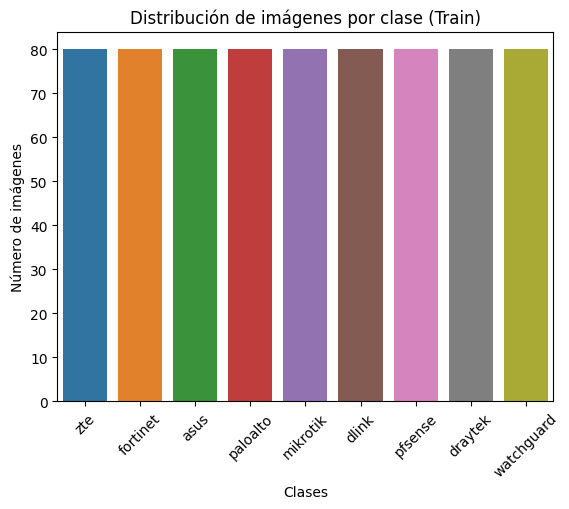

Distribución de imágenes en el conjunto de prueba:


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


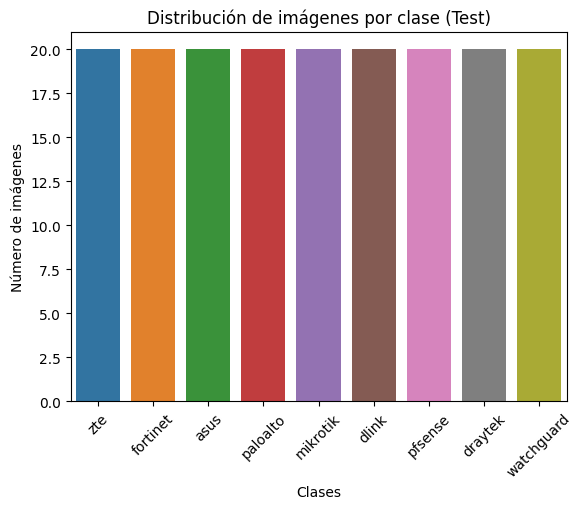

In [6]:
# Visualización de la distribución de imágenes
def plot_distribution(data, title):
    sns.barplot(x=list(data.keys()), y=list(data.values()))
    plt.title(title)
    plt.xlabel("Clases")
    plt.ylabel("Número de imágenes")
    plt.xticks(rotation=45)
    plt.show()

print("Distribución de imágenes en el conjunto de entrenamiento:")
plot_distribution(train_counts, "Distribución de imágenes por clase (Train)")

print("Distribución de imágenes en el conjunto de prueba:")
plot_distribution(test_counts, "Distribución de imágenes por clase (Test)")


In [7]:
# Paso 3: Crear conjuntos de datos
image_height, image_width = 682, 1366

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(image_height, image_width),  # Cambia según tus necesidades
    batch_size=batchsize_for_training
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(image_height, image_width),
    batch_size=batchsize_for_training
)

Found 720 files belonging to 9 classes.
Found 180 files belonging to 9 classes.


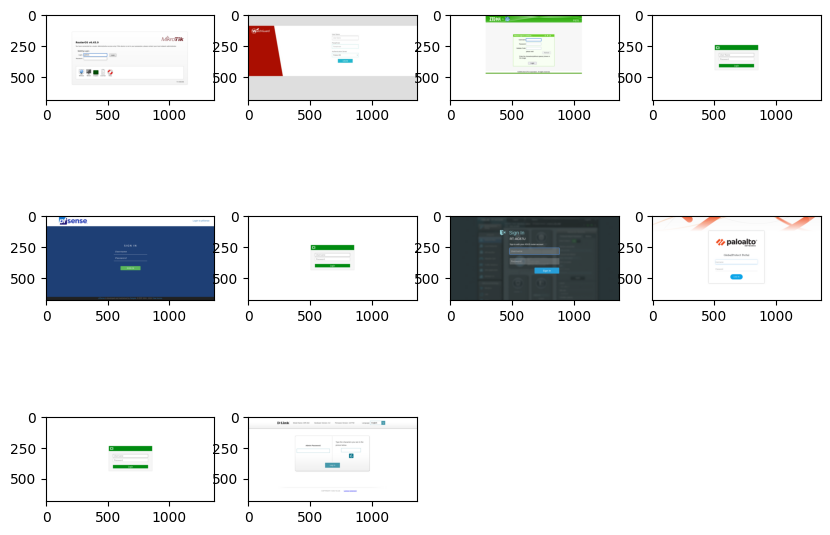

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(10):
    for i in range(10):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

In [9]:
for images, labels in train_dataset.take(10):
    print(labels)

tf.Tensor([2 6 0 2 0 7 3 4 4 5 5 5 2 2 4 3], shape=(16,), dtype=int32)
tf.Tensor([7 5 3 4 2 2 3 5 2 3 7 6 7 2 6 5], shape=(16,), dtype=int32)
tf.Tensor([3 2 8 2 1 2 1 6 2 1 3 6 3 6 5 6], shape=(16,), dtype=int32)
tf.Tensor([7 0 7 6 4 1 2 7 6 4 0 5 1 5 7 0], shape=(16,), dtype=int32)
tf.Tensor([8 4 1 7 3 8 7 1 0 7 0 4 7 3 7 6], shape=(16,), dtype=int32)
tf.Tensor([0 6 5 7 4 2 7 1 1 6 7 1 4 3 3 7], shape=(16,), dtype=int32)
tf.Tensor([2 7 4 0 1 0 6 2 0 4 8 1 8 1 1 6], shape=(16,), dtype=int32)
tf.Tensor([1 1 8 5 2 4 2 4 4 6 3 3 1 8 8 6], shape=(16,), dtype=int32)
tf.Tensor([1 0 8 3 0 6 5 5 6 1 2 6 0 6 2 0], shape=(16,), dtype=int32)
tf.Tensor([3 6 8 4 2 4 6 0 7 4 2 5 7 6 2 6], shape=(16,), dtype=int32)


In [10]:
image_height, image_width = 682, 1366


# Importamos los elementos de Keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input, 
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.optimizers import (Adam, RMSprop, SGD)
from keras import Sequential, Model, initializers
from tensorflow.keras.metrics import SparseCategoricalAccuracy

initializer = initializers.RandomNormal(seed=11)

num_classes = len(fabricantes)

# # Definir el modelo secuencial
# model = Sequential()

# # Primera capa de convolución y agrupamiento
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Segunda capa de convolución y agrupamiento
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Tercera capa de convolución y agrupamiento
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Aplanar y capas densas
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))  # Regularización
# model.add(Dense(num_classes, activation='softmax'))


# Paso 4: Crear una red CNN
model = models.Sequential([
    layers.Input(shape=(image_height, image_width, 3)),
    layers.CenterCrop(height=300, width=600, data_format='channels_last'),
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(96, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(712, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.2),
    layers.Dense(496, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.3),
    layers.Dense(328, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Una clase por fabricante
])


# Compilación del modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[SparseCategoricalAccuracy()])


# # Compilación del modelo
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=[CategoricalAccuracy()])

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ center_crop (CenterCrop)             │ (None, 300, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 300, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 298, 598, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 299, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 297, 64)        │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 148, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 69, 144, 96)         │         153,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 34, 72, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 235008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 712)                 │     167,326,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 712)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 496)                 │         353,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 496)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 328)                 │         163,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 328)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          84,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,093,033 (641.22 MB)

 Trainable params: 168,093,033 (641.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entrenar el modelo
callback = EarlyStopping(monitor='loss',patience=2)

history = model.fit(
    train_dataset,
    epochs=epochs_for_training,
    batch_size=batchsize_for_training,
    callbacks=[callback]
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - loss: 4.0961 - sparse_categorical_accuracy: 0.1937
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.8200
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.2198 - sparse_categorical_accuracy: 0.9460
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9769
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9907
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9896
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9903


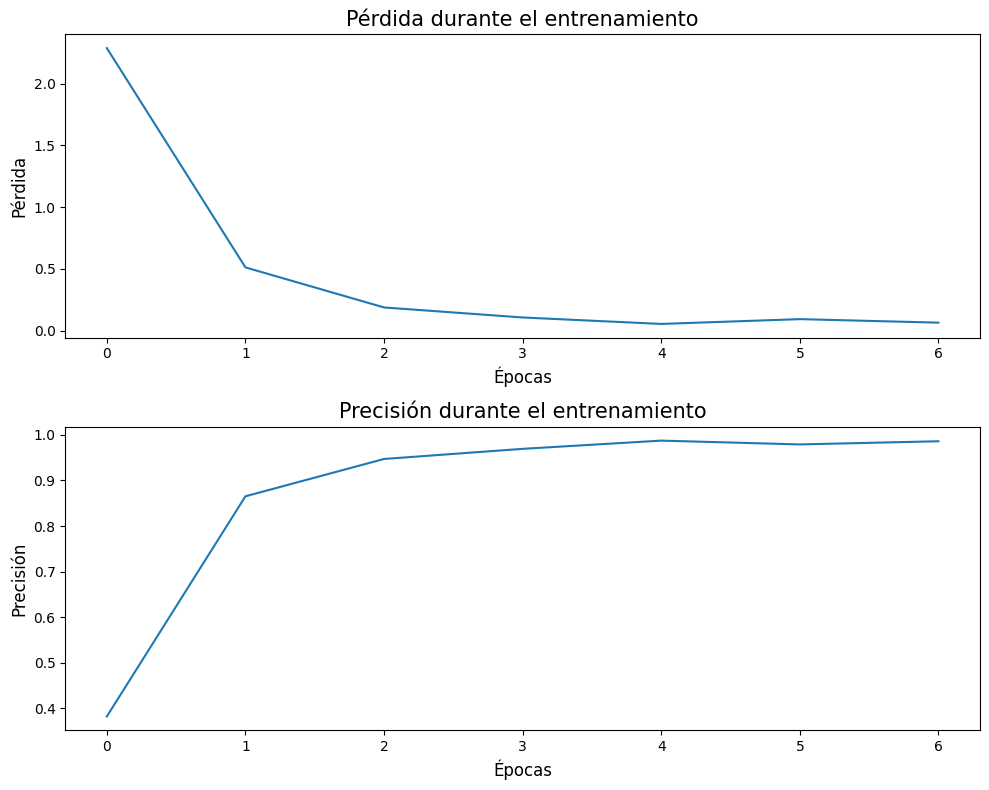

In [12]:
# Graficar pérdida y precisión
def plot_training_history(history):
    # Graficar la pérdida
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    #plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento', fontsize=15)
    plt.xlabel('Épocas',fontsize=12)
    plt.ylabel('Pérdida',fontsize=12)

    # Graficar la precisión
    plt.subplot(2, 1, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Entrenamiento')
    #plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validación')
    plt.title('Precisión durante el entrenamiento', fontsize=15)
    plt.xlabel('Épocas',fontsize=12)
    plt.ylabel('Precisión',fontsize=12)
    plt.tight_layout()

    plt.savefig('wysiwyg_cnn_training.png')
    plt.show()

# Llamar a la función para graficar
plot_training_history(history)

In [13]:
# Evaluación del modelo

loss, accuracy = model.evaluate(test_dataset)
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0984 - sparse_categorical_accuracy: 0.9894
Precisión en el conjunto de prueba: 0.99


In [14]:
# Paso 5: Generar la matriz de confusión
# Obtener etiquetas verdaderas y predichas
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
print(true_labels)
print(len(true_labels))

pred_probs = model.predict(test_dataset)
pred_labels = np.argmax(pred_probs, axis=1)

print(pred_labels)
print(len(pred_labels))

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Normalizar la matriz para obtener valores porcentuales
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #* 100

[4 6 2 3 7 0 2 3 0 1 3 0 3 3 7 2 7 0 0 5 7 2 3 0 0 8 5 5 7 6 7 4 3 0 8 6 0
 6 5 7 7 6 4 0 2 1 3 2 3 4 4 5 5 2 2 4 2 1 8 3 3 7 4 8 0 1 8 5 8 5 1 5 1 6
 1 4 5 3 6 4 6 8 2 8 4 7 0 6 3 5 3 5 6 2 7 8 8 4 6 0 8 2 3 4 5 6 0 2 3 2 5
 2 0 0 8 5 7 1 5 1 4 7 8 0 7 6 4 6 4 8 5 0 1 7 6 3 6 1 8 1 8 3 1 6 4 5 4 5
 7 1 8 1 7 7 7 8 5 1 6 2 6 0 4 6 3 4 1 4 2 8 2 1 1 1 7 0 3 2 8 2]
180
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
[6 7 6 7 2 2 1 8 3 2 2 4 3 2 5 3 5 5 8 6 1 0 2 3 1 8 7 1 4 4 6 0 7 7 6 7 8
 5 3 3 8 3 6 3 8 2 8 4 3 3 7 6 2 0 8 5 8 3 8 7 0 6 1 7 2 0 7 7 3 3 2 0 2 0
 2 4 4 1 7 1 7 2 3 5 6 4 0 5 4 6 2 5 4 6 4 5 4 3 1 0 1 6 8 6 7 1 0 2 7 4 7
 2 6 8 7 0 6 8 0 7 0 5 3 6 1 5 1 4 1 5 1 3 2 5 1 5 8 6 7 8 0 0 0 8 8 1 4 2
 3 6 1 5 6 4 4 8 2 6 4 8 4 5 2 0 7 5 4 1 3 1 8 4 0 5 5 6 0 1 5 3]
180


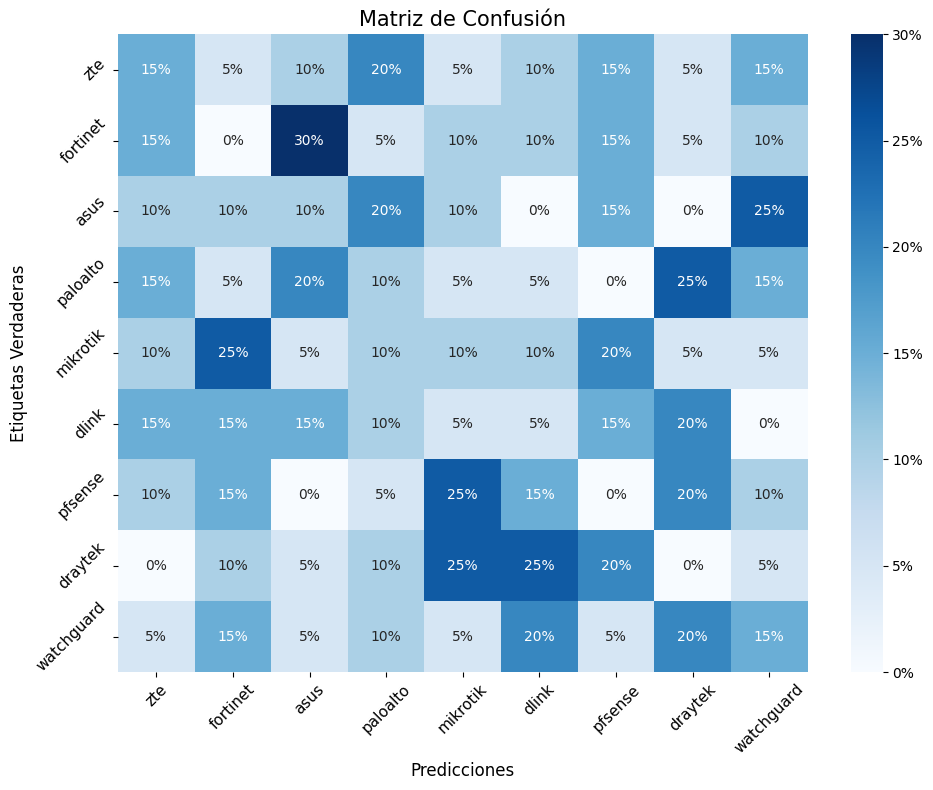

Reporte de clasificación:
              precision    recall  f1-score   support

         zte       0.16      0.15      0.15        20
    fortinet       0.00      0.00      0.00        20
        asus       0.10      0.10      0.10        20
    paloalto       0.10      0.10      0.10        20
    mikrotik       0.10      0.10      0.10        20
       dlink       0.05      0.05      0.05        20
     pfsense       0.00      0.00      0.00        20
     draytek       0.00      0.00      0.00        20
  watchguard       0.15      0.15      0.15        20

    accuracy                           0.07       180
   macro avg       0.07      0.07      0.07       180
weighted avg       0.07      0.07      0.07       180



In [15]:
# Visualizar la matriz de confusión
fmt = lambda x,pos: '{:.0%}'.format(x)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    fmt='.0%',
    xticklabels=fabricantes,
    yticklabels=fabricantes,
    cmap='Blues',
    cbar_kws={'format': FuncFormatter(fmt)}
)
plt.title("Matriz de Confusión",fontsize=15)
plt.xlabel("Predicciones",fontsize=12)
plt.ylabel("Etiquetas Verdaderas",fontsize=12)
plt.xticks(rotation=45,fontsize=11)
plt.yticks(rotation=45,fontsize=11)
plt.tight_layout()
plt.savefig('wysiwyg_cnn_conf_matrix.png')
plt.show()

# Reporte detallado
print("Reporte de clasificación:")
print(classification_report(true_labels, pred_labels, target_names=fabricantes))